<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit

--- 
# Notebook 2

The second notebook will clean the data from the reddit scrapping and perfrom simple exploratory data analysis.

---

# 0. Import Package and Read in Data


In [18]:
#!pip install emoji

In [1]:
import pandas as pd
import numpy as np
import emoji as emj
import re

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Reading in both datasets
df_cats = pd.read_csv('./dataset/cats.csv', encoding='utf-8', low_memory = False) # Add in encoding to read in chinese characters
df_cats = df_cats[['subreddit', 'title']].reset_index(drop = True)

df_dogs = pd.read_csv('./dataset/dogs.csv', encoding='utf-8', low_memory = False) # Add in encoding to read in chinese characters
df_dogs = df_dogs = df_dogs[['subreddit', 'title']].reset_index(drop = True)

# Appending the dogs titles below the cats titles
df_reddit = df_cats.append(df_dogs, ignore_index = True)
df_reddit.tail() # Checking tails to see if the dogs titles has been successfully appended.

,subreddit,title
19986,dogs,RIP: Mary- Toy Poodle 6 years old
19987,dogs,Border Collie
19988,dogs,Are clementines okay for dogs?
19989,dogs,[help] choosing a companion for our current dog
19990,dogs,Dog doesnt like to interact with other dogs


In [3]:
# Checking number of rows and columns
df_reddit.shape

(19991, 2)

# 1.1 Data Cleaning - Extracting Emojis
We will perform the following steps to clean the data
* Extracting emojis and put in new column
* Extracting websites and put in new column
* Change all text to lower case
* Remove punctuations
* Remove non-english characters

In [6]:
# Note that to run this block of codes, 
# run jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 at anacondas prompt to optimise

# This block of codes removes the emojis from title and put them into a new column in df_reddit
EMOJIS = emj.UNICODE_EMOJI

def extract_emoji(df):
    df["emoji"] = ""
    for index, row in df.iterrows():
        for emoji in EMOJIS:
            if emoji in row["title"]:
                row["title"] = row["title"].replace(emoji, "")
                row["emoji"] += emoji

extract_emoji(df_reddit)

# 1.2 Data Cleaning - Extracting Website

In [ ]:
df_reddit['website'] = ''
df_reddit['website'] = df_reddit['title'].str.extract(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))")
df_reddit['title'] = df_reddit['title'].str.replace(r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', regex = True)

In [24]:
storage_list = df_reddit[df_reddit['title'] == ''].index

In [25]:
# Create empty dataframe df_storage for storing the rows with empty titles but with emojis or url
df_storage = pd.DataFrame(columns=df_reddit.columns)

# Use a for loop to store the rows with emojis but not titles
for x in storage_list:
    df_storage = df_storage.append(df_reddit.iloc[x])

In [26]:
# Saving to csv to join with main dataframe again.
df_reddit.to_csv('./dataset/storage.csv', index = False)

# 1.3 Data Cleaning - Lower Case, Remove Punctuations, Remove Foreign Languages

In [27]:
# Change text to lower case
df_reddit['title'] = df_reddit['title'].str.lower()

In [28]:
# Remove punctuation
df_reddit['title'] = df_reddit['title'].str.replace(r'[^\w\s]+', '', regex = True)

In [29]:
# Remove non ascii characters in order to remove other languages
df_reddit = df_reddit[df_reddit['title'].map(lambda x: x.isascii())]
df_reddit.reset_index(drop = True, inplace = True)

In [30]:
df_reddit.shape

(19922, 3)

By mapping title to ascii removes some rows with other languages. Some titles with english mixed with other languages are also removed. The total number of rows removed is 69 which is less than 0.5% of our data and therefore is not a significant loss of data.

By putting isascii() as the last step helps to remove emojis first so that titles with english and emojis are retained.

# 2. Missing Values
After performing basic cleaning, there are empty fields in titles which needs to be removed before we can split the sentence into words using countvectorise.

In [31]:
df_reddit.isna().sum()

subreddit    0
title        0
website      0
dtype: int64

In [32]:
df_reddit.iloc[[1430]]

,subreddit,title,website
1430,cats,,


Although the isna() method returns 0 rows with missing data in title, there are still blank spaces within the dataset as shown above. These blanks are probably due to foreign languages.

In [33]:
# Extract the indexes of empty titles and storing in a list
null_list = df_reddit[(df_reddit['title'] == '')].index

In [34]:
# Before we can create a loop to drop all the rows whose titles are empty
# we need to create a list in running numbers of the length and add to the indexes
# as the indexes will shift up each time we drop a row
ordered_list = list(range(len(null_list)))
null_list = null_list - ordered_list

In [ ]:
# Use a for loop to drop all empty titles where the emoji column is also blank
for x in null_list:
    df_reddit.drop(df_reddit.index[x], axis=0, inplace=True)

# Resetting index after dropping
df_reddit.reset_index(drop = True, inplace = True)

In [36]:
# Check correct number of rows deleted.
print(len(null_list))
df_reddit.shape

55


(19867, 3)

Checking the number of rows before dropping is 19922 and after dropping is 19854 which is 68 rows drop. As it is meaningless to impute values in nlp, the right thing to do is to drop missing values. Additionally, the number of rows drop is small and less than 0.4% of the data thus it is not require to scrap more data.

# 3.0 Distribution of Data
Before we look at the distribution of data, lets remove duplicate first. Duplicate titles will cause certain words to have high count after separating the titles to words and may become potential outliers

In [ ]:
# Remove white spaces before and after the title
df_reddit['title'] = df_reddit['title'].str.strip()

# Remove double white spaces in title
df_reddit = df_reddit.replace('\s+', ' ', regex=True)

# Check for duplicates
df_reddit.duplicated(subset = 'title').sum()

In [38]:
# Drop duplicates
df_reddit.drop_duplicates(inplace = True, ignore_index = True)
df_reddit.shape

(19278, 3)

555 rows of duplicated data is dropped.

# 3.1 Distribution of Data - Emoji

In [ ]:
# Mapping rows with website links to 1 and without to 0
df_reddit['website'] = np.where(df_reddit['website'].isnull(), 0, 1)

# Mapping rows with emojis to 1 and without to 0
df_reddit['emoji'] = np.where(df_reddit['emoji'] == '', 0, 1)

# Mapping dogs to 1 and cats to 0
df_reddit['subreddit'] = np.where(df_reddit['subreddit'] == 'dogs', 1, 0)

In [ ]:
sns.countplot(x = 'subreddit', hue = 'emoji', data = df_reddit);

The graph shows that subreddit cats has much more emojis than subreddit dogs. This means that cat lovers express themselves more through emojis than dog lovers.

# 3.2 Distribution of Data - Word Count

In [42]:
# Creating a column to store the number of words of each title
df_reddit['word_count'] = df_reddit['title'].map(lambda x: len(x.split()))
df_reddit.head()

,subreddit,title,website,word_count
0,cats,i came home sick from work with pneumonia here...,1,23
1,cats,my sleepyhead curled up this morning,1,6
2,cats,spooky takes care of me when i wfh who needs h...,1,15
3,cats,hi i am a new cat mom and am hoping someone mi...,1,25
4,cats,spooky looks after me when i wfh who needs a h...,1,19


In [43]:
df_reddit.sort_values(by='word_count', ascending=False)[['word_count']]

,word_count
2326,64
210,63
8425,63
3658,63
577,62
...,...
14838,1
1854,1
18859,1
13452,1


The highest number of word count for title is 64 and the lowest is 1.

<Figure size 432x288 with 0 Axes>

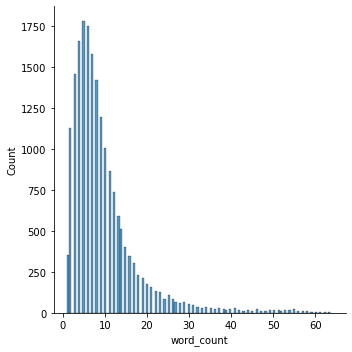

In [44]:
plt.suptitle('Distribution of Word Count', fontsize=15)

sns.displot(df_reddit['word_count'], kde=False);

The distribution of word count is right skewed. Most of the word count lies between 1 to 15 with the rest stretching to 64.  This is coomon as most people do not use too much words in their title.

The peak word count is about 5 to 7.

# 3.3 Distribution of Data - Title Length

In [45]:
# Create a new column to store length of title
df_reddit['title_length'] = df_reddit['title'].map(len)

# Display the top 5 longest titles
pd. set_option('display.max_colwidth', None)
df_reddit.sort_values(by='title_length', ascending=False)[['title']].head()

,title
11174,i love cocker spaniels because cocker spaniels are affectionate dogs that enjoy spending time with their owners and their families cockers have an excellent personality and are an ideal breed of dog for someone looking for a pet that enjoys company i recently got one and it had the biggest smile
7897,everyone knows that cats do not have a fixed price and they are constantly changing according to factors such as appearance and ancestry among all the english shorts the blue ones will be relatively expensive cats are not recommended to trade in different places try to choose the same city as p
7594,since august this baby has been gone but today we managed to track him down bcs of a lovely family on facebook i missed him so much and cried when i touched him again he ie back in his home all good and still remembers every room lt3 im so happy he walked to a whole new city we are all suprised
1783,update on my new adopted cat mrs kitty odd name but thats what previous owners named her shes finally decided not to hide is starting to eat and drink more frequently and has started using her litter box apparently she has chose me as her person because she hardly ever leaves my side so happy
2813,hello my name is martijntje and i am a student from the rottedam business school i am conducting a research regarding a fictional company called wispurrbed it is a company that specalizes in cat beds i need to find out if they could do business in latvia the survey is anonymous and in latvian


<Figure size 432x288 with 0 Axes>

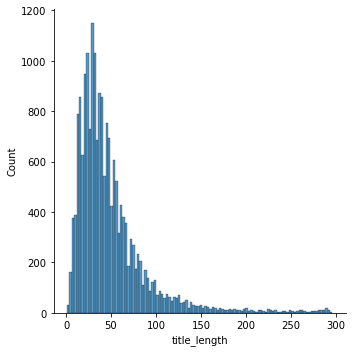

In [46]:
plt.suptitle('Distribution of Title Length', fontsize=15)

sns.displot(df_reddit['title_length'], kde=False);

The distribution of title length is right skewed. The length of majority of the titles lies between 1 to 100 with some of the titles been exceptionally long to about 300. This is a normal trend as most people tend to keep their titles short.

The peak title length is about 30 to 40 in length.

# 4. Outliers

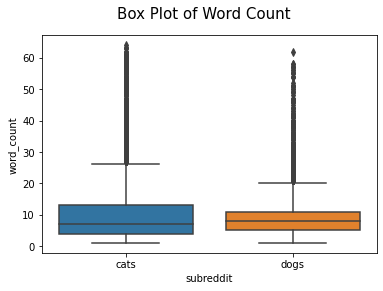

In [47]:
plt.suptitle('Box Plot of Word Count', fontsize=15)

sns.boxplot(x='subreddit', y='word_count', data = df_reddit);

The titles from subreddit dogs contains more words than titles from subreddit cats. Although both reddit have alot of outliers in terms of word count but it may not matter once we split the title into individual words. However, we need to take note of posts with repeated words. This will unnecessary add to certain words been a more important feature and picked up during machine learning.

In [48]:
# Displaying a title with repeated words
df_reddit['title'].iloc[18420]

'older dog attacked new puppy'

In [49]:
# Function to remove duplicate words in
def Remove_Duplicates(sentence):
    regex = r"\b(\w+)(?:\W\1\b)+"
    return re.sub(regex, r"\1", sentence)

df_reddit['title'] = df_reddit['title'].map(Remove_Duplicates)

In [50]:
# Check to see duplicated words remove
df_reddit['title'].iloc[18420]

'older dog attacked new puppy'

# 5. Summary Statistics

In [51]:
df_reddit.describe()

,website,word_count,title_length
count,19278.0,19278.000000,19278.000000
mean,1.0,9.700176,49.331051
std,0.0,8.283585,40.871999
min,1.0,1.000000,1.000000
25%,1.0,5.000000,24.000000
50%,1.0,7.000000,38.000000
75%,1.0,12.000000,60.000000
max,1.0,64.000000,296.000000


The summary statistics do not show any issues with the data.

In [52]:
# Saving the lemmatized version of the data
df_reddit.to_csv('./dataset/cleaned.csv', index = False)

# 6. Exploratory Data Analysis
We will first lemmatize the titles then use count Vectoriser to split up the words and find the most common words.

In [53]:
# Instantiate lemmatizer.
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    sentence = " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])
    return sentence

df_reddit['title'] = df_reddit['title'].apply(lemmatize_text)

df_reddit.head()

,subreddit,title,website,word_count,title_length
0,cats,i came home sick from work with pneumonia here is where i found my wife cat watching tv then noticing me taking picture,1,23,121
1,cats,my sleepyhead curled up this morning,1,6,36
2,cats,spooky take care of me when i wfh who need hr when youve got haww,1,15,67
3,cats,hi i am a new cat mom and am hoping someone might have experience with something similar to my cat ear detail in post comment,1,25,128
4,cats,spooky look after me when i wfh who need a hr department when you can have a haww department,1,19,94


In [55]:
X = df_reddit['title']

# Instantiate a CountVectorizer with the default hyperparameters.
cvec = CountVectorizer(stop_words='english', max_features = 20)

# Fit the vectorizer on our corpus and transform it.
X_vec = cvec.fit_transform(X)

# Create a dataframe after count vectoriser
df_vec_reddit = pd.DataFrame(X_vec.todense(), columns = cvec.get_feature_names())

# Pulling out the top 15 words
df_vec_reddit.sum().sort_values(ascending=False).head(20)

dog       6308
cat       3520
help      1076
new        868
year       816
like       756
ha         743
just       719
old        690
puppy      673
wa         651
love       565
doe        534
need       528
im         521
breed      497
advice     484
kitten     448
little     446
day        443
dtype: int64

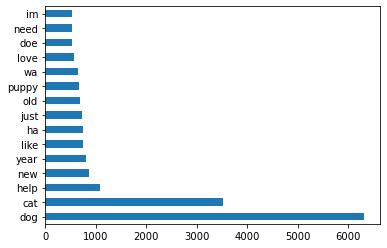

In [56]:
df_vec_reddit.sum().sort_values(ascending=False).head(15).plot(kind='barh');

# 7. Initial Assessment of Problem Statement

After exploratory data analysis, the following evidence shows possibility that the model will score well.
* Posts from subreddit cats contains a lot more emojis than posts from subreddit dogs.
* The top 20 words after counttokeniser shows that there are about 7500 instances of dog, puppy and breed which is about 75% of the posts from subreddit dogs. 
* Although there are only about 4000 instances of the words cat and kitten, there is still a high chance the model will perform well to predict the source of the subreddit by learning from other words.